In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import gdown
from zipfile import ZipFile

In [ ]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=64
)
dataset = dataset.map(lambda x: (x / 127.5)-1) # 127.5-1

Found 202599 files belonging to 1 classes.


(64, 64, 64, 3)
<dtype: 'float32'>


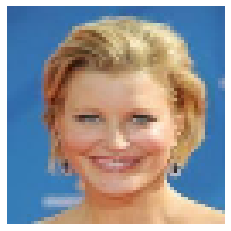

In [ ]:
for x in dataset:
    print(x.shape)
    print(x.dtype)
    plt.axis("off")
    plt.imshow(((x.numpy()+1)*127.5).astype("int32")[0])
    break

In [ ]:
def build_generator_model():
    model = tf.keras.Sequential() # Keras 모델 생성

    model.add(layers.Dense(1024, input_dim=200, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(8*8*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Resahpe (8*8)
    model.add(layers.Reshape((8, 8, 256)))  
    
    model.add(layers.Conv2DTranspose(256, (5, 5), 
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    
    # (8*8) -> (16*16)
    model.add(layers.Conv2DTranspose(128, (5, 5), 
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # (16*16) -> (32*32)
    model.add(layers.Conv2DTranspose(64, (5, 5), 
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [ ]:
generator = build_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              204800    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             16777216  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0

In [ ]:
def build_discriminator_model():

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same', input_shape=[64, 64, 3])) # input image size
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

In [ ]:
# 생성자용
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 판별자용
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# 생성자 모델 목표 : 
# 판별자 모델이 가짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1과 가짜 이미지를 판별 값 비교 후 에러 값이 낮아지도록

In [ ]:
# 판별자 모델 목표 :
# 1. 진짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
# 2. 가짜 이미지를 판별했을 때 판별 값이 0에 가까워지도록
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1. 1과 진짜 이미지 판별 값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 2. 0과 가짜 이미지 판별 값 비교
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
EPOCHS = 300
noise_dim = 200

In [ ]:
@tf.function # 빠르게 하기 위해?
def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([64, noise_dim])
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
      fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
test_noise = tf.random.normal([10, noise_dim]) # 학습 시각화를 위한 테스트 노이즈

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(64, 64,3)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
    plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs): # 전체 데이터 학습 반복 횟수(300)
  
    for image_batch in dataset: # batch 학습(64)
      train_step(image_batch)

    print("%s epochs trained" % epoch)

    if epoch % 5 == 0: # 5번째 에포크 마다 이미지 시각화
        show_generated_images(epoch)

In [ ]:
train(dataset, EPOCHS)

In [ ]:
test_noise = tf.random.normal([1, noise_dim])
images = generator.predict(test_noise)
images = 0.5 * images + 0.5
plt.imshow(images.reshape(64,64,3))